In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13,8)
#%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# APEX Gun example

In [3]:
import sys, os
root = os.path.join(os.getcwd(), '../')

sys.path.append(root)

GPT_IN = os.path.join(root, 'templates/apex_gun/gpt.in')
DISTGEN_IN = os.path.join(root, 'templates/apex_gun/distgen.yaml')

from gpt import GPT
from distgen import Generator

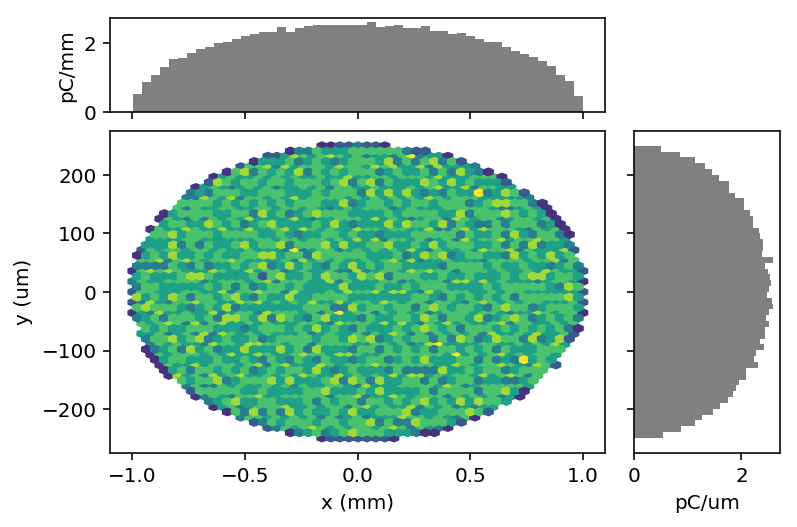

In [4]:
G = Generator(DISTGEN_IN)
G['n_particle'] = 10000

G.run()
P0 = G.particles
factor = 2
P0.x *= factor  
P0.y *= 1/factor 
P0.plot('x', 'y')

In [5]:
G = GPT(input_file=GPT_IN, initial_particles=P0, verbose=True)

GPT.configure_gpt:
   Original input file "gpt.in" in "/Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/apex_gun"
   Configured to run in "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14"


In [6]:
# Set some of these
variables_were_set = G.set_variables({'gun_peak_field':20e6,'gun_phase':171.340,'tmax': 4e-7, 'RadiusMax':.015,
                                      'Ntout':2000,
                                     'dtmin':0,
                                     'GBacc':8,
                                       'xacc':8,
                                      'space_charge':1
                                     })
print(variables_were_set)

{'gun_peak_field': True, 'gun_phase': True, 'tmax': True, 'RadiusMax': True, 'Ntout': True, 'dtmin': True, 'GBacc': True, 'xacc': True, 'space_charge': True}


In [7]:
# Run
G.run()
PF = G.particles[-1]
len(G.particles), PF['mean_z'], PF['mean_kinetic_energy']/1e3

GPT.run_gpt:
   Initial particles written to "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf"
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
   Running GPT...
   Writing gpt input file to "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.in"

General Particle Tracer - Oct 28 2014
   Loading GPT data from /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.out.gdf
   GDF data loaded, time ellapsed: 1.46509 (sec).
   Converting tout and screen data to ParticleGroup(s)
   Run finished, total time ellapsed: 2960.4 (sec)


(5, 0.19914932966730908, 765.6582679275674)

In [8]:
G.initial_particles

<ParticleGroup with 10000 particles at 0x151fec05f8>

In [9]:
import numpy as np

from pmd_beamphysics.particles import single_particle
P0 = single_particle()
G.initial_particles  = P0

def phaseit(phase):
    G.verbose=False
    G.set_variables({'gun_phase':phase})
    try:
        G.run()
        return G.particles[-1]['mean_kinetic_energy']/1e3
    except:
        return 0

In [10]:
from scipy.optimize import brent

brent(lambda x: -phaseit(x%360), brack=(0, 360), maxiter=20, tol=1e-6, full_output=False) %360

/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmp

171.37341704721916

In [11]:
plist = np.linspace(170, 172, 10)
enlist = np.array([phaseit(p) for p in plist])

/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf
/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpnrj4ox14/gpt.particles.gdf


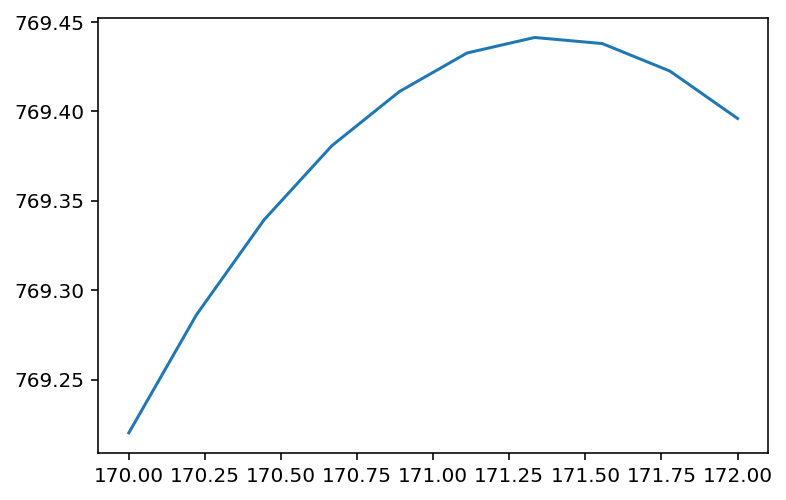

In [12]:
plt.plot(plist, enlist)

# Plot trajectories

In [13]:
G.particles[0]._settable_array_keys

['x', 'px', 'y', 'py', 'z', 'pz', 't', 'status', 'weight', 'id']

In [14]:
import numpy as np
from matplotlib import pyplot as plt

# Make trajector structure here for now, should go somewhere else as a function



rs ={}
for t in G.particles:
    for ID in t['id']:
        idint=int(ID)
        res = np.where(t['id']==ID)
        index = res[0][0]
        
        if(ID not in rs.keys()):
            rs[idint]={'x':[],'y':[],'z':[], 't':[], 'GBz':[]}
        else:
            rs[idint]['x'].append(t['x'][index])
            rs[idint]['y'].append(t['y'][index])
            rs[idint]['z'].append(t['z'][index])
            rs[idint]['t'].append(t['t'][index])
          #  rs[idint]['GBz'].append(t['GBz'][index])
         

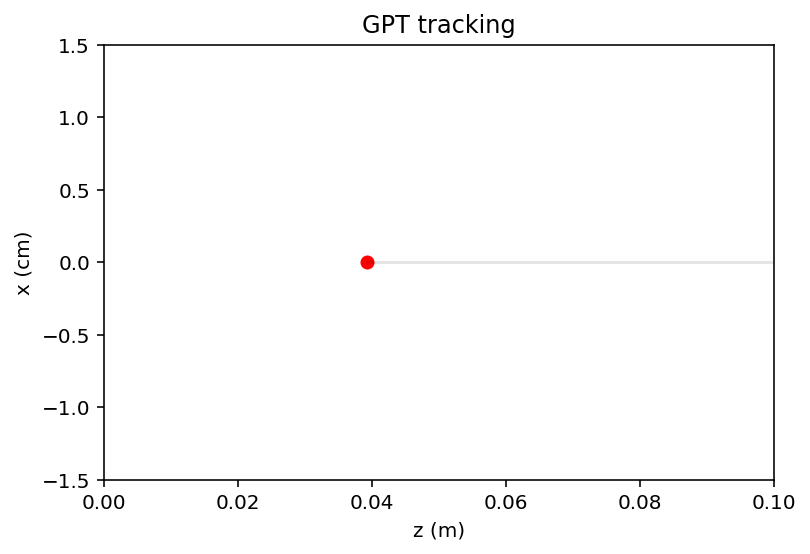

In [15]:
for ind in rs.keys():
    for var in rs[ind]:
        rs[ind][var]=np.array(rs[ind][var])

for ind in rs.keys():
    plt.plot(rs[ind]['z'][0],rs[ind]['x'][0]*1e2, color='red', marker='o')
    plt.plot(rs[ind]['z'],rs[ind]['x']*1e2, color='black', alpha=0.1)

plt.ylim(-1.5, 1.5)
plt.xlim(0, 0.1)
plt.title('GPT tracking')
plt.xlabel('z (m)');
plt.ylabel('x (cm)');

In [16]:
zlist = np.array([P['mean_z'] for P in G.particles])


In [17]:
np.argmin(abs(zlist - 0.15))

3

In [18]:
G.particles[3]['mean_z']

0.149055844340028

In [20]:
#G.particles[3].write('$HOME/Scratch/gpt_apex_100pC_4x.h5')

In [21]:
G.archive('gpt_apex_gun.h5')

'gpt_apex_gun.h5'

In [22]:
G2 = GPT()
G2.load_archive('gpt_apex_gun.h5')

In [23]:
G2.particles[3]['mean_z']

0.149055844340028

In [24]:
G.tout

[<ParticleGroup with 1 particles at 0x1520466710>,
 <ParticleGroup with 1 particles at 0x152046f438>,
 <ParticleGroup with 1 particles at 0x10c2d9b38>,
 <ParticleGroup with 1 particles at 0x1520487240>]

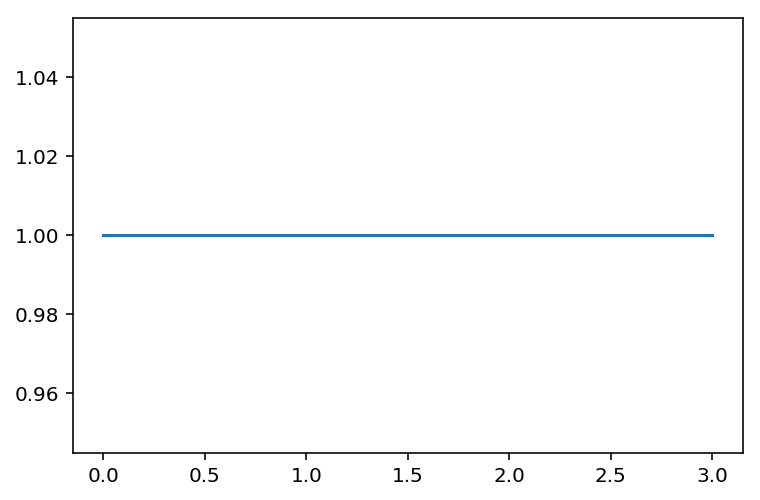

In [25]:
plt.plot(np.array([P['n_particle'] for P in G.particles]))